# Deeplearning - Anees Ahmad - 2021/08/08

# 9 Advanced deep learning for computer vision

## 9.1 Three essential computer vision tasks

- Image classification
  - The goal is to assign one or more labels to an image.
    - It may be either single-label classification
      - an image can only be in one category, excluding the others
    - or multi-label classification
      - tagging all categories that an image belongs to
- Image segmentation
  - The goal is to “segment” or “partition” an image into different areas, with each area usually representing a category
- Object detection
  - The goal is to draw rectangles (called bounding boxes) around objects of interest in an image, and associate each rectangle with a class.
- Image similarity scoring
  - estimating how visually similar two images are
- keypoint detection
  - pinpointing attributes of interest in an image
- Pose estimation
- 3D mesh estimation

## 9.2 An image segmentation example

- Image segmentation with deep learning is about using a model to assign a class to each pixel in an image, thus segmenting the image into different zones
- two different flavors of image segmentation
  - Semantic segmentation
    - where each pixel is independently classified into a semantic category
  - Instance segmentation
    - which seeks not only to classify image pixels by category, but also to parse out individual object instances

-  Oxford-IIIT Pets dataset
  - contains 7,390 pictures of various breeds of cats and dogs, together with foreground-background segmentation masks for each picture. 
    - A segmentation mask is the image-segmentation equivalent of a label
      - it’s an image the same size as the input image, with a single color channel where each integer value corresponds to the class of the corresponding pixel in the input image.
        - 1 (foreground)
        - 2 (background)
        - 3 (contour)

In [1]:
# Download Data
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-06-04 17:05:11--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-06-04 17:05:12--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  14.4MB/s    in 55s     

2022-06-04 17:06:08 (13.8 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-06-04 17:06:08--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

In [2]:
# list of input file paths, as well as the list of the corresponding mask file paths
import os
 
input_dir = "images/"
target_dir = "annotations/trimaps/"
 
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

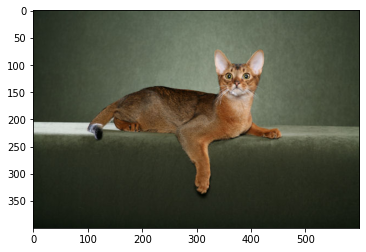

In [3]:
# inputs image
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import load_img, img_to_array
 
# plt.axis("off")
plt.imshow(load_img(input_img_paths[0])) 

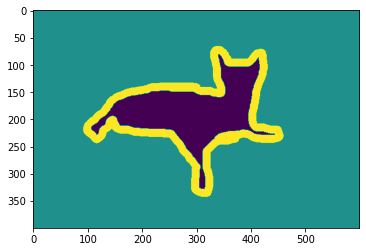

In [4]:
# mask of the same image
def display_target(target_array):
  # as labels are 1,2 and 3 - change it to 0,1 and 2 - multiplation change it to (black, grey and white)
  normalized_array = (target_array.astype("uint8") - 1) * 127
  # plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])
 
img = img_to_array(load_img(target_paths[0], color_mode="grayscale"))
display_target(img)

In [5]:
# load our inputs and targets into two NumPy arrays
# split the arrays into a training and a validation set

import numpy as np 
import random 
 
# resize
img_size = (200, 200)
# total images
num_imgs = len(input_img_paths)
# shuffle arrays
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

# load input image to array and resize
def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

# load output image resize and greyscale
def path_to_target(path):
  img = img_to_array(
      load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8") - 1
  return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i]) 

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:
# Define the model
from tensorflow import keras 
from tensorflow.keras import layers
 
def get_model(img_size, num_classes):
  inputs = keras.Input(shape=img_size + (3,))
  x = layers.Rescaling(1./255)(inputs)
  x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
  x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
  x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)
  outputs = layers.Conv2D(num_classes, 3, activation="softmax",padding="same")(x)
  model = keras.Model(inputs, outputs)
  return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

- first half
  - Conv2D
    -  encode the images into smaller feature maps, where each spatial location contains information about a large spatial chunk of the original image
  - strides
    - we care a lot about the spatial location of information in the image, since we need to produce perpixel target masks as output of the model.
    - strided convolutions do a better job at downsampling feature maps while retaining location information.
- second half
  - Conv2DTranspose
    - inverse of the transformations

In [7]:
# compile and fit
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
 
callbacks = [
  keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
  save_best_only=True)
]
 
history = model.fit(
    train_input_imgs, train_targets,
    epochs=50,
    callbacks=callbacks,
    batch_size=64,
    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 87s 682ms/step - loss: 1.1109 - val_loss: 0.9942
Epoch 2/50
100/100 [==============================] - 63s 635ms/step - loss: 0.9242 - val_loss: 0.8843
Epoch 3/50
100/100 [==============================] - 63s 634ms/step - loss: 0.8178 - val_loss: 0.7648
Epoch 4/50
100/100 [==============================] - 63s 629ms/step - loss: 0.7843 - val_loss: 0.6999
Epoch 5/50
100/100 [==============================] - 63s 633ms/step - loss: 0.7260 - val_loss: 0.6769
Epoch 6/50
100/100 [==============================] - 63s 631ms/step - loss: 0.6748 - val_loss: 0.6264
Epoch 7/50
100/100 [==============================] - 63s 633ms/step - loss: 0.6424 - val_loss: 0.5769
Epoch 8/50
100/100 [==============================] - 63s 632ms/step - loss: 0.6192 - val_loss: 0.5487
Epoch 9/50
100/100 [==============================] - 63s 632ms/step - loss: 0.5842 - val_loss: 0.6580
Epoch 10/50
100/100 [==============================] - 63s 633ms/step - l

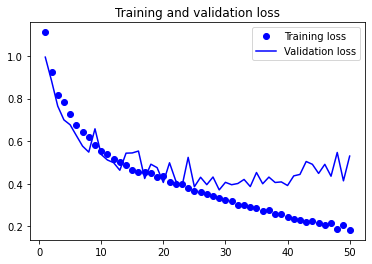

In [8]:
# training and validation loss
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [17]:
# # reload our best performing model according to the validation loss
# # demonstrate how to use it to predict a segmentation mask

from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")
 
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

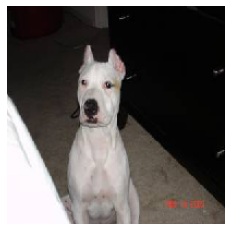

In [32]:
i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

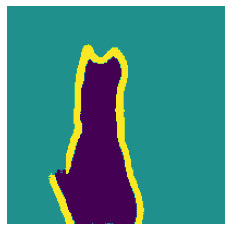

In [33]:
mask = model.predict(np.expand_dims(test_image, 0))[0]
display_mask(mask)

---